<a href="https://colab.research.google.com/github/kashyapneelabh26/Salary-classification/blob/main/KNN_Classifier_and_Decision_Tree_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import sys

# New Section

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import sys
sys.path += ['/content/drive/My Drive/Projects/Classifiers-1']

In [15]:
from nutil import *

In [16]:
import math
import csv
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

**Immutable classes**

In [17]:
class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



**Mutable Classes**

In [18]:
class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        class_counts = Counter(y)
        total_samples = len(y)
        self.probabilities_ = {label: count / total_samples for label, count in class_counts.items()}
        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        y = np.random.choice(list(self.probabilities_.keys()), size=len(X), p=list(self.probabilities_.values()))
        return y



**Immutable Functions**

In [19]:
def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend()

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1]
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    return data, bins, align, labels


**Mutable Functions**

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    # Compute cross-validation error using StratifiedShuffleSplit over ntrials
    train_errors = []
    test_errors = []
    f1_scores = []

    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)

    for train_idx, test_idx in sss.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        train_error = 1 - metrics.accuracy_score(y_train, y_train_pred)
        test_error = 1 - metrics.accuracy_score(y_test, y_test_pred)

        f1 = f1_score(y_test, y_test_pred, average='micro')

        train_errors.append(train_error)
        test_errors.append(test_error)
        f1_scores.append(f1)

    avg_train_error = np.mean(train_errors)
    avg_test_error = np.mean(test_errors)
    avg_f1_score = np.mean(f1_scores)

    return avg_train_error, avg_test_error, avg_f1_score

    return train_error, test_error, f1_score




**Immutable functions**

In [21]:
def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


**Main**

Plotting...


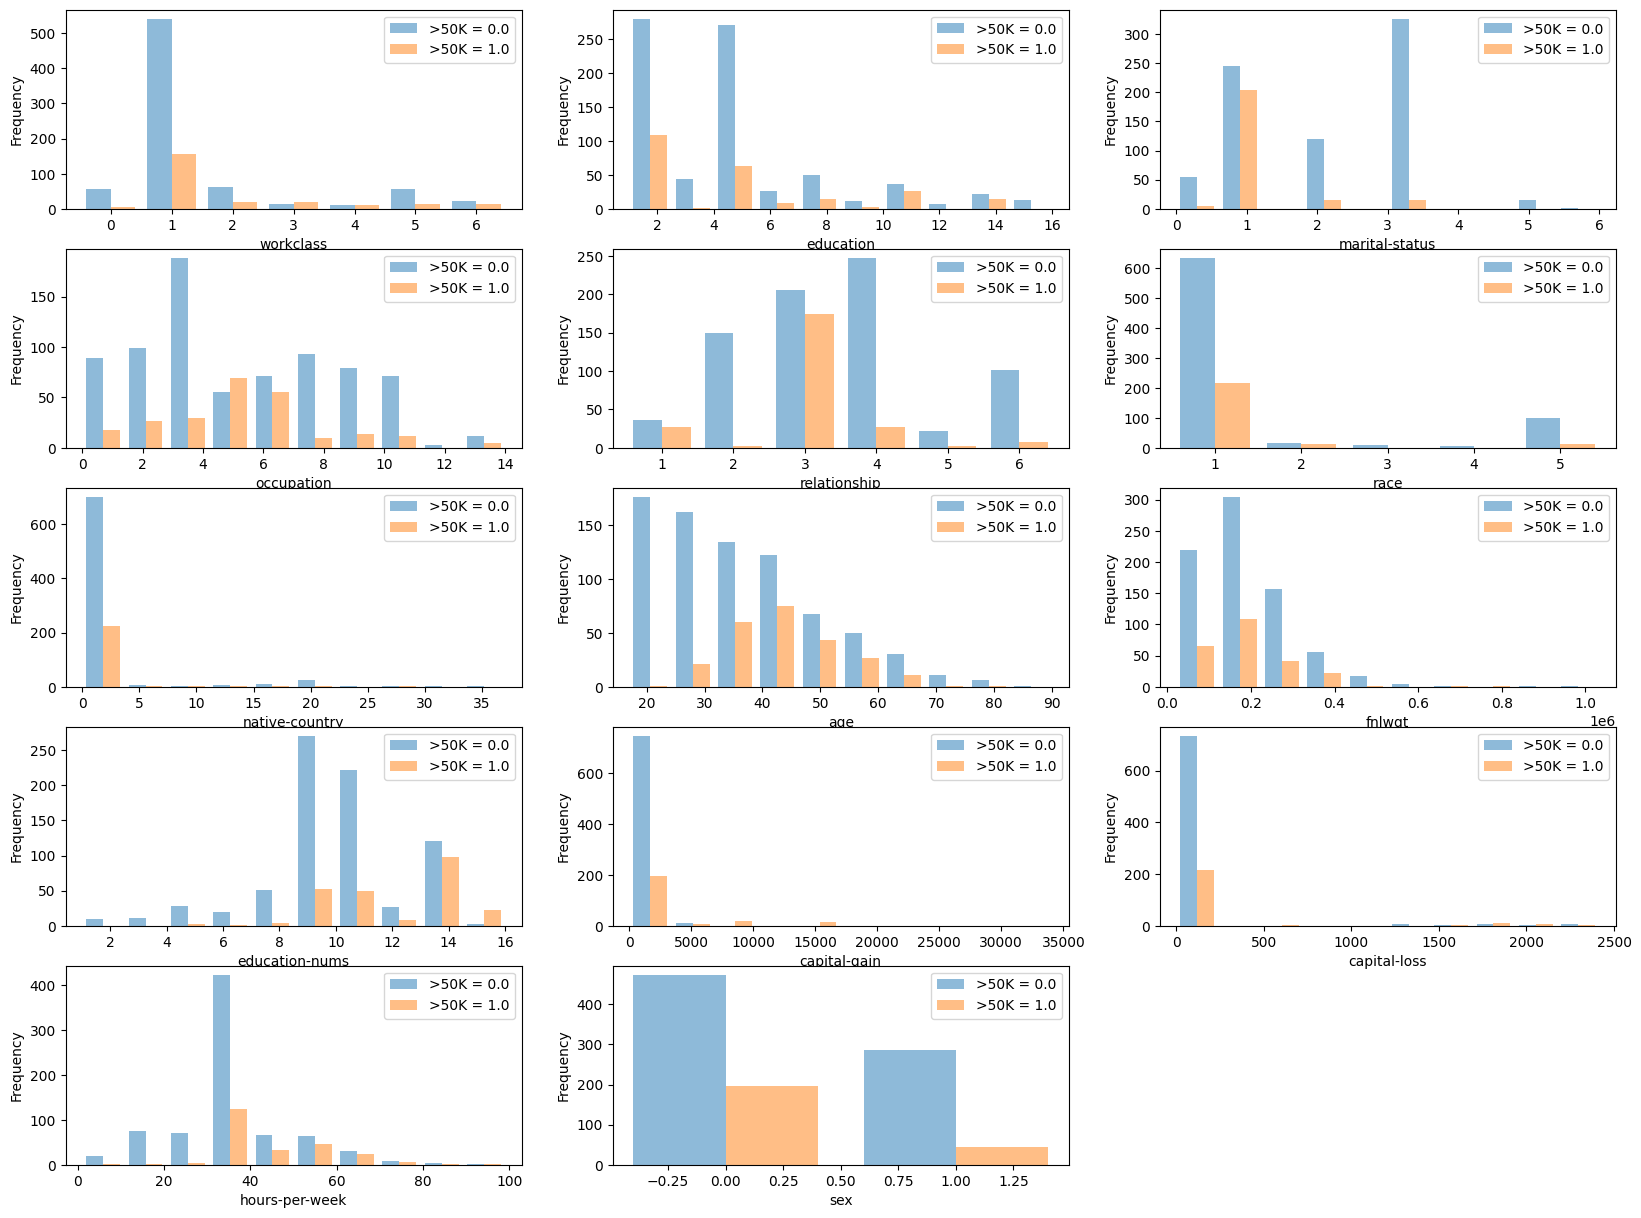

Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.385
Classifying using Decision Tree...
Training Error of DecisionTreeClassifier: 0.0
Classifying using k-Nearest Neighbors...
Training Error of KNeighborsClassifier (k=3): 0.121
Training Error of KNeighborsClassifier (k=5): 0.147
Training Error of KNeighborsClassifier (k=7): 0.165
Investigating various classifiers...
MajorityVoteClassifier:
Avg Train Error = 0.24000000000000005, Avg Test Error = 0.24000000000000005, Avg F1 Score = 0.76
RandomClassifier:
Avg Train Error = 0.375, Avg Test Error = 0.3809999999999999, Avg F1 Score = 0.619
DecisionTreeClassifier:
Avg Train Error = 0.0, Avg Test Error = 0.20074999999999998, Avg F1 Score = 0.7992499999999999
KNeighborsClassifier:
Avg Train Error = 0.1334375, Avg Test Error = 0.2065, Avg F1 Score = 0.7935000000000001
Finding the best k...


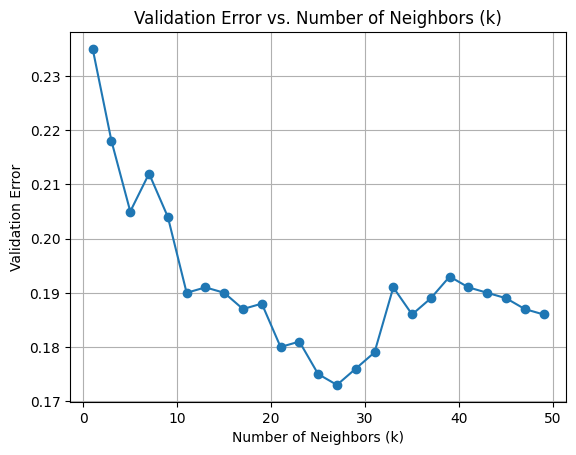

The best value of k is 27
Investigating depths...


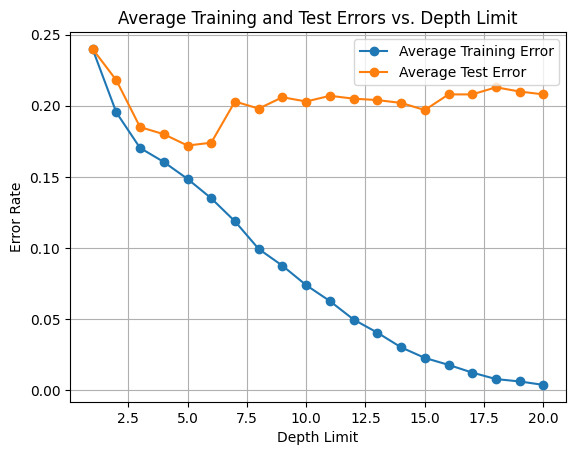

The best depth limit is 5


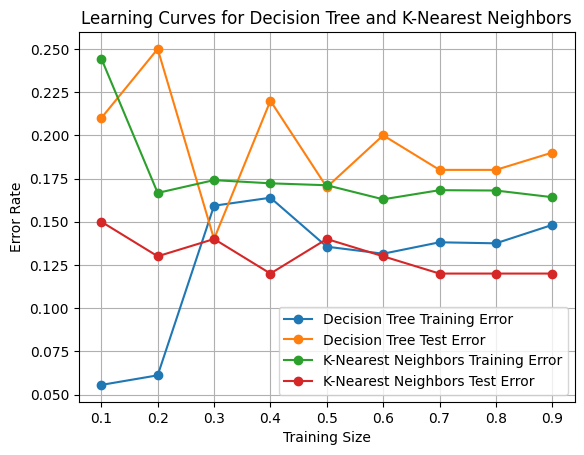

Done


In [23]:
def main():

    data_file =  "/content/drive/My Drive/Projects/Classifiers-1/adult_subsample.csv"
    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape



    # Histograms
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    plt.show()

    # Preprocessing
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier()
    clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    # Evaluate training error of Random classifier
    print('Classifying using Random...')
    clf = RandomClassifier ()
    clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    # Evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize, train and make predictions using the DecisionTreeClassifier
    tree_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
    tree_classifier.fit(X_train, y_train)
    y_train_pred = tree_classifier.predict(X_train)

    # Evaluate the training error
    training_error = 1 - metrics.accuracy_score(y_train, y_train_pred)
    print(f"Training Error of DecisionTreeClassifier: {training_error}")



    # Evaluate training error of k-Nearest Neighbors classifier
    print('Classifying using k-Nearest Neighbors...')
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize and train the KNeighborsClassifier for different values of k
    k_values = [3, 5, 7]
    for k in k_values:
      knn_classifier = KNeighborsClassifier(n_neighbors=k)
      knn_classifier.fit(X_train, y_train)
      y_train_pred = knn_classifier.predict(X_train)
      training_error = 1 - metrics.accuracy_score(y_train, y_train_pred)
      print(f"Training Error of KNeighborsClassifier (k={k}): %.3f" % training_error)

    # Cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    # MajorityVoteClassifier
    majorityvote_classifier = MajorityVoteClassifier()
    majorityvote_summary = error(majorityvote_classifier, X, y, ntrials=20)
    print("MajorityVoteClassifier:")
    print(f"Avg Train Error = {majorityvote_summary[0]}, Avg Test Error = {majorityvote_summary[1]}, Avg F1 Score = {majorityvote_summary[2]}")

    # RandomClassifier
    random_classifier = RandomClassifier()
    random_summary = error(random_classifier, X, y, ntrials=20)
    print("RandomClassifier:")
    print(f"Avg Train Error = {random_summary[0]}, Avg Test Error = {random_summary[1]}, Avg F1 Score = {random_summary[2]}")

    # DecisionTreeClassifier
    decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
    tree_summary = error(decision_tree_classifier, X, y, ntrials=20)
    print("DecisionTreeClassifier:")
    print(f"Avg Train Error = {tree_summary[0]}, Avg Test Error = {tree_summary[1]}, Avg F1 Score = {tree_summary[2]}")

    # KNeighborsClassifier
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_summary = error(knn_classifier, X, y, ntrials=20)
    print("KNeighborsClassifier:")
    print(f"Avg Train Error = {knn_summary[0]}, Avg Test Error = {knn_summary[1]}, Avg F1 Score = {knn_summary[2]}")

    #10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    k_values = list(range(1, 51, 2))

    # Perform 10-fold cross-validation for each value of k
    validation_errors = []
    for k in k_values:
      knn_classifier = KNeighborsClassifier(n_neighbors=k)
      scores = cross_val_score(knn_classifier, X, y, cv=10, scoring='accuracy')
      validation_error = 1 - np.mean(scores)
      validation_errors.append(validation_error)

    # Validation error vs the number of neighbors (k)
    plt.plot(k_values, validation_errors, marker='o')
    plt.title('Validation Error vs. Number of Neighbors (k)')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Validation Error')
    plt.grid(True)
    plt.show()

    best_k = k_values[np.argmin(validation_errors)]
    print(f"The best value of k is {best_k}")

    # Decision tree classifier with various depths
    print('Investigating depths...')
    depth_limits = list(range(1, 21))
    avg_train_errors = []
    avg_test_errors = []

    for depth_limit in depth_limits:

        tree_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=depth_limit, random_state=0)

        scores = cross_validate(tree_classifier, X, y, cv=10, scoring=('accuracy'), return_train_score=True)

        avg_train_error = 1 - np.mean(scores['train_score'])
        avg_test_error = 1 - np.mean(scores['test_score'])

        avg_train_errors.append(avg_train_error)
        avg_test_errors.append(avg_test_error)

    # Plot the average training and test errors against the depth limit and find the best depth
    plt.plot(depth_limits, avg_train_errors, label='Average Training Error', marker='o')
    plt.plot(depth_limits, avg_test_errors, label='Average Test Error', marker='o')
    plt.title('Average Training and Test Errors vs. Depth Limit')
    plt.xlabel('Depth Limit')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    best_depth_limit = depth_limits[np.argmin(avg_test_errors)]
    print(f"The best depth limit is {best_depth_limit}")

    # Decision tree and k-Nearest Neighbors classifier with various training set sizes
    best_depth_limit = 5
    best_k_value = 15

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    training_sizes = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]


    dt_train_errors = []
    dt_test_errors = []
    knn_train_errors = []
    knn_test_errors = []

    for training_size in training_sizes:

        X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=training_size, random_state=0, shuffle=True)

        # Decision Tree Classifier
        dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth_limit, random_state=0)
        dt_classifier.fit(X_train_subset, y_train_subset)
        dt_train_pred = dt_classifier.predict(X_train_subset)
        dt_test_pred = dt_classifier.predict(X_test)
        dt_train_errors.append(1 - metrics.accuracy_score(y_train_subset, dt_train_pred))
        dt_test_errors.append(1 - metrics.accuracy_score(y_test, dt_test_pred))

        # K-Nearest Neighbors Classifier
        knn_classifier = KNeighborsClassifier(n_neighbors=best_k_value)
        knn_classifier.fit(X_train_subset, y_train_subset)
        knn_train_pred = knn_classifier.predict(X_train_subset)
        knn_test_pred = knn_classifier.predict(X_test)
        knn_train_errors.append(1 - metrics.accuracy_score(y_train_subset, knn_train_pred))
        knn_test_errors.append(1 - metrics.accuracy_score(y_test, knn_test_pred))

    # Learning curves
    plt.plot(training_sizes, dt_train_errors, label='Decision Tree Training Error', marker='o')
    plt.plot(training_sizes, dt_test_errors, label='Decision Tree Test Error', marker='o')
    plt.plot(training_sizes, knn_train_errors, label='K-Nearest Neighbors Training Error', marker='o')
    plt.plot(training_sizes, knn_test_errors, label='K-Nearest Neighbors Test Error', marker='o')
    plt.title('Learning Curves for Decision Tree and K-Nearest Neighbors')
    plt.xlabel('Training Size')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('Done')


if __name__ == "__main__":
    main()
